## Setup requirements and mounting drive

In [ ]:
!pip install transformers

In [57]:
import warnings
warnings.filterwarnings('ignore')

import torch
import os
import torchvision.models as models
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader , Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torch.nn as nn
from sklearn.model_selection import train_test_split
from random import randint
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import logging

## Dataloader

In [71]:
DATASET_DIR = "/home/diluksha/Dataset/pacs_data/pacs_data/art_painting/dog"
Image_size = 224

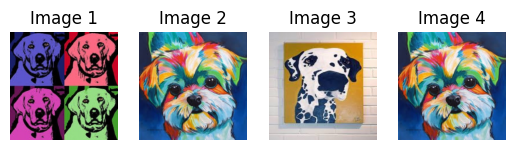

In [72]:
image_files = os.listdir(DATASET_DIR)

# Number of images to visualize
num_images_to_visualize = 4

for i in range(num_images_to_visualize):
    image_path = os.path.join(DATASET_DIR, image_files[i+randint(0,20)])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(image)
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()

In [73]:
def data_loader(train_data_dir, valid_data_dir, test_data_dir, batch_size, random_seed=38, valid_size=0.1, shuffle=True):

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((Image_size,Image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            normalize,
    ])

    train_dataset = ImageFolder(root=train_data_dir, transform=transform)
    valid_dataset = ImageFolder(root=valid_data_dir, transform=transform)
    test_dataset = ImageFolder(root=test_data_dir, transform=transform)

    train_indices, _ = train_test_split(list(range(len(train_dataset))), train_size=0.05, random_state=random_seed)

    # Create DataLoader for train and test sets
    train_dataset = torch.utils.data.Subset(train_dataset, train_indices)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader


In [74]:
#Define batch_size
batch_size = 16

DIR={
    "P": "/home/diluksha/Dataset/pacs_data/pacs_data/photo",
    "A": "/home/diluksha/Dataset/pacs_data/pacs_data/art_painting",
    "C": "/home/diluksha/Dataset/pacs_data/pacs_data/cartoon",
    "S": "/home/diluksha/Dataset/pacs_data/pacs_data/sketch"
}

#set the relevant domain as train, valid, test sets
train_dataloader, validation_dataloader, test_dataloader = data_loader(DIR["P"],DIR["A"],DIR["S"],batch_size)


## Architecture

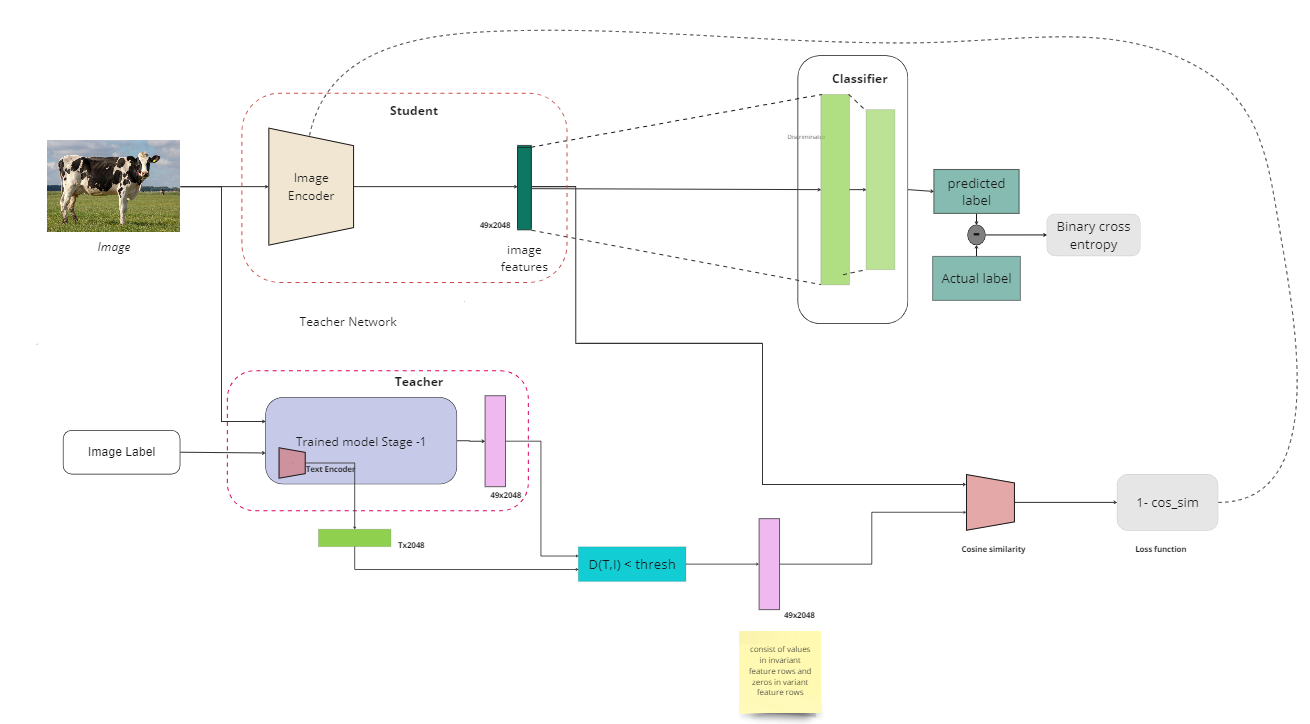

## Student Encoder with classifier

In [75]:
#Student feature extractor + Classifier
class StudentNet(nn.Module):
  def __init__(self,hidden_layers = 2048, num_classes = 7):
    super(StudentNet,self).__init__()

    #download resnet152 model
    model = models.resnet152(pretrained=True)
    self.cropped_resnet152 = torch.nn.Sequential(*list(model.children())[:-2])

    #for classifier
    self.avgpool = nn.AvgPool2d(7, stride=1)
    self.fc = nn.Linear(hidden_layers, num_classes)

  def forward(self, image):
    img_embedding = self.cropped_resnet152(image)
    x = self.avgpool(img_embedding)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return img_embedding,x


## Teacher Image encoder

In [76]:
import torch.nn as nn
class TeacherNet(nn.Module):
  def __init__(self):
    super(TeacherNet,self).__init__()
    model = models.resnet152(pretrained=True)
    self.cropped_resnet152 = torch.nn.Sequential(*list(model.children())[:-2])

  def forward(self, image):
    self.outputs = self.cropped_resnet152(image)
    return self.outputs


## Teacher text Encoder

In [77]:

class TextEncoder(nn.Module):
  def __init__ (self):
    super(TextEncoder,self).__init__()
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.bert_model = BertModel.from_pretrained('bert-base-uncased')
    self.gru = nn.GRU(input_size=768, hidden_size=1024, bidirectional=True, batch_first=True) #outputformat: [N,L,D*hidden_size] ; N-batch_size, L- sequence_length, D=2 if bidirectional

    #Move the models to GPU if cuda available
    if torch.cuda.is_available():
      self.bert_model = self.bert_model.to('cuda:0')
      self.gru = self.gru.to('cuda:0')


  def forward(self,label):
    tokenized_statements = [self.tokenizer.encode(label)]
    input_ids = torch.tensor(tokenized_statements)

    #Move the token tensor to GPU if cuda available
    if torch.cuda.is_available():
      input_ids = input_ids.to('cuda:0')


    with torch.no_grad():
      outputs = self.bert_model(input_ids )

    word_vectors = outputs.last_hidden_state #shape [1, token_size, 768]
    gru_outputs, _ = self.gru(word_vectors)

    #remove head and tail vector
    gru_outputs = gru_outputs[0][1:-1]
    return gru_outputs



## Distance Function

In [78]:
## Euclidean distance between embeddings
def embedding_distance(text_emb, img_emb, thresh: float= 0.5):
  # Compute the Euclidean distance ---------------------------> check for any better distance function
  euclidean_distance = torch.norm(text_emb - img_emb)
  if euclidean_distance.item() <= float(thresh):
    return True
  else:
    return False

def Ideal_teacher_nn_output_matrix(text_embeddings, Image_embeddings, threshold):
  zero_tensor = torch.zeros_like(Image_embeddings)
  idx = 0
  Image_embeddings = torch.reshape(Image_embeddings,[Image_embeddings.shape[0],2048,49])
  for i in range(Image_embeddings.shape[2]):
      region_em = Image_embeddings[:,:,i]
      is_inside = embedding_distance(text_embeddings, region_em, threshold)
      if is_inside:
        zero_tensor[idx] = region_em
      idx+=1

  return zero_tensor

## Loss function

In [79]:

class SimilarityLoss(nn.Module):

    def __init__(self):
        super(SimilarityLoss, self).__init__()


    def forward(self, teacher_em, student_em):
      cs = F.cosine_similarity(teacher_em , student_em, dim=1)
      mean_cs = torch.mean(cs)
      loss = torch.ones_like(mean_cs) - mean_cs
      return loss

## Defining model

In [80]:
class Knowledge_distiller(nn.Module):
    def __init__(self, hidden_layers = 2048, p_size = 2, num_classes = 2):
        super(Knowledge_distiller, self).__init__()

        self.student_net = StudentNet(num_classes = num_classes)

        #freezing weights of teacher
        self.teacher_img_net = TeacherNet()
        for param in self.teacher_img_net.parameters():
          param.requires_grad = False

        self.teacher_txt_net = TextEncoder()
        for param in self.teacher_txt_net.parameters():
          param.requires_grad = False

        if torch.cuda.is_available():
          self.student_net = self.student_net.to('cuda:0')
          self.teacher_img_net = self.teacher_img_net.to('cuda:0')
          self.teacher_img_net = self.teacher_img_net.to('cuda:0')



    def forward(self, image, label, threshold):
      txt_emb = self.teacher_txt_net(label)
      teacher_img_emb = self.teacher_img_net(image)

      student_img_emb,x = self.student_net(image)
      ideal_teacher_out = Ideal_teacher_nn_output_matrix(txt_emb, teacher_img_emb, threshold)

      return x, teacher_img_emb, student_img_emb





## Training

In [81]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [82]:
if torch.cuda.is_available():
    model = Knowledge_distiller(num_classes = 7)
    model = model.to('cuda:0') # model moved to specified GPU
    print("Model loaded to GPU.")
else:
    model = Knowledge_distiller(num_classes = 7)
    print("GPU is unavailable. model loaded to CPU.")

Model loaded to GPU.


In [83]:
#Learnable parameters
total_params = sum(para.numel() for para in model.parameters() if para.requires_grad)

print(f"Number of learnable parameters: {total_params}")

Number of learnable parameters: 58158151


In [84]:
criterion_1 = SimilarityLoss() # Loss function for knowledge distillation
criterion_2 = nn.CrossEntropyLoss() #Loss function for classifier
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [85]:
#PACS classes
labels = {
    "0":"Dog",
    "1":"Elephant",
    "2":"Giraffe",
    "3":"Guitar",
    "4":"Horse",
    "5":"House",
    "6":"Person"
}

In [86]:
# Define a directory to save your model and checkpoints
save_dir = 'FYP_OOD/Diluksha/Stage_2/Checkpoints/Model_checkpoints_for_distiller'

# Make sure the directory exists, create it if it doesn't
if not os.path.exists(save_dir):
    os.makedirs(save_dir)



## Training Feature extractor of student by freezing classifier

In [87]:
#training only student network (classifier-> freeze)
for name, param in model.named_parameters():
   if name in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

Epochs = 10
training_loss = []
threshold = 10 # threshold value for classify invariant and variant features

logging.basicConfig(filename="Distillation.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

for i in tqdm(range(Epochs)) :
    epoch_loss = 0
    count = 0;
    for batch , (image , label) in enumerate(train_dataloader) :
        label_tensor=[]
        for idx, val in enumerate(label):
          label_tensor.append(labels[str(label[idx].item())])

        #Moving Img_data to GPU
        if torch.cuda.is_available():
          image = image.to('cuda:0')

        x, teacher_img_emb, student_img_emb = model(image, label_tensor, threshold)
        #Calculating loss
        loss = criterion_1(teacher_img_emb,student_img_emb)
        print(batch)

        if batch % 100 == 0:
            print(f"Looked at {batch * len(image)}/{len(train_dataloader.dataset)} samples.")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss +=loss

    training_loss.append((epoch_loss/len(train_dataloader)).cpu().detach().numpy())
    print(f"Epoch {i+1}: Loss: {training_loss[-1]}\n\n")

    # Save the model and training checkpoint
    if (i + 1) % 2 == 0:  # Save every 2 epochs, adjust as needed
        # Save the model's state dictionary
        model_checkpoint_path = os.path.join(save_dir, f'model_epoch_{i+1}.pt')
        torch.save(model.state_dict(), model_checkpoint_path)

        # Save training checkpoint information
        checkpoint = {
            'epoch': i + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': training_loss[-1]
        }
        checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{i+1}.pt')
        torch.save(checkpoint, checkpoint_path)

        # Log the saved paths and other details
        logging.info(f'Epoch {i+1} - Model saved to: {model_checkpoint_path}')
        logging.info(f'Epoch {i+1} - Checkpoint saved to: {checkpoint_path}')

logging.shutdown()


  0%|          | 0/10 [00:00<?, ?it/s]

0
Looked at 0/83 samples.
1
2
3
4


 10%|█         | 1/10 [00:02<00:24,  2.77s/it]

5
Epoch 1: Loss: 0.21346434950828552


0
Looked at 0/83 samples.
1
2
3
4
5
Epoch 2: Loss: 0.34219032526016235




 20%|██        | 2/10 [00:21<01:36, 12.02s/it]

0
Looked at 0/83 samples.
1
2
3
4


 30%|███       | 3/10 [00:24<00:56,  8.02s/it]

5
Epoch 3: Loss: 0.3210519552230835




KeyboardInterrupt: ignored

In [ ]:
#model

# Taking off the student net away from teacher network

In [ ]:
final_model = model.student_net
#freezing image encoder
for name, param in model.named_parameters():
    if 'cropped_resnet152' in name:
        param.requires_grad = False

In [ ]:
#final_model

In [ ]:
# Define a directory to save your model and checkpoints
save_dir = 'FYP_OOD/Diluksha/Stage_2/Checkpoints/Model_checkpoints_for_classifier'

# Make sure the directory exists, create it if it doesn't
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


# Training for the classifier by freezing feature extractor

In [ ]:
Epochs = 10
training_loss = []

logging.basicConfig(filename="Classification.log", level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

for i in tqdm(range(Epochs)) :
    epoch_loss = 0
    count = 0;
    for batch , (image , label) in enumerate(train_dataloader) :

        if torch.cuda.is_available():
          image = image.to('cuda:0')

        y = final_model(image)
        if torch.cuda.is_available():
          label = label.to('cuda:0')

        loss = criterion_2(y[1], label)

        if batch % 500 == 0:
            print(f"Looked at {batch * len(image)}/{len(train_dataloader.dataset)} samples.")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss +=loss

    training_loss.append((epoch_loss/len(train_dataloader)).cpu().detach().numpy())
    print(f"Epoch {i+1}: Loss: {training_loss[-1]}\n\n")

    # Save the model's state dictionary
    model_checkpoint_path = os.path.join(save_dir, f'model_epoch_{i+1}.pt')
    torch.save(model.state_dict(), model_checkpoint_path)

    # Save training checkpoint information
    checkpoint = {
            'epoch': i + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': training_loss[-1]
    }
    checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{i+1}.pt')
    torch.save(checkpoint, checkpoint_path)

    # Log the saved paths and other details
    logging.info(f'Epoch {i+1} - Model saved to: {model_checkpoint_path}')
    logging.info(f'Epoch {i+1} - Checkpoint saved to: {checkpoint_path}')


logging.shutdown()

# The final model testing

In [ ]:
image_path = '/home/diluksha/Dataset/pacs_data/pacs_data/cartoon/dog/pic_001.jpg'
image = Image.open(image_path)
plt.imshow(image)


In [ ]:

normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
transform = transforms.Compose([
            transforms.Resize((Image_size,Image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            normalize,
    ])

input_tensor = transform(image)

input_tensor = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
      input_tensor = input_tensor.to('cuda:0')


In [ ]:
final_model.eval()
with torch.no_grad():
      output = final_model(input_tensor)
predict = np.argmax(F.softmax(output[1].cpu())).item()

print(labels[str(predict)])